# HuggingFace Transformers Tutorial

Course: Stanford CS224N<br/>
Author: Ben Newman

Thanks to Anna Goldie for feedback!

Adapted by Giuseppe Attardi for the Course HLT, University of Pisa.

This notebook provides an introduction to the HuggingFace Transformers Python library and some common patterns that you can use to take advantage of it. It is most useful for using or fine-tuning pretrained transformer models for your projects.

HuggingFace provides access to models (both the code that implements them and their pre-trained weights), model-specific tokenizers, as well as pipelines for common NLP tasks, and datasets and metrics in a separate `datasets` package. It has implementations in PyTorch, Tensorflow, and Flax (though we'll be using the PyTorch versions here!)

We're going to go through a few use cases:
* Overview of Tokenizers and Models
* Finetuning - for your own task. We'll use a sentiment-classification example.

Here are additional resources introducing the library that were used to make this tutorial:

* [HuggingFace Docs](https://huggingface.co/docs/transformers/index)
  * Clear documentation
  * Tutorials, walk-throughs, and example notebooks
  * List of available models
* [HuggingFace Course](https://huggingface.co/course/)
* [HuggingFace O'Reilly Book](https://www.oreilly.com/library/view/natural-language-processing/9781098103231/)

In [1]:
!pip install transformers
!pip install datasets

In [1]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

def print_encoding(model_inputs, indent=4):
    "Display tokenized inputs to model."
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

## Part 1: Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction

![full_nlp_pipeline](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

2023-04-04 08:13:51.148975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 08:14:04.246110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-04 08:14:04.246323: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-04 08:14:04.246339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [3]:
inputs = "I'm excited to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")

Input:
I'm excited to learn about Hugging Face Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,  1532,    59, 30581,  3923, 12346,
         34379,   328,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7605,  2.9262]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


### 1.1 Tokenizers

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.


You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.

In [4]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")  # written in Rust
print(tokenizer)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # convenient! Defaults to Fast
print(tokenizer)

DistilBertTokenizer(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)
DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [5]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is great!"
tokenized_inputs = tokenizer(input_str)


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

Vanilla Tokenization
{
    input_ids:
        [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
    attention_mask:
        [1, 1, 1, 1, 1, 1, 1, 1, 1]
}

[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
[101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]


In [6]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

start:                 Hugging Face Transformers is great!
tokenize:              ['Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!']
convert_tokens_to_ids: [20164, 10932, 10289, 25267, 1110, 1632, 106]
add special tokens:    [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
--------
decode:                [CLS] Hugging Face Transformers is great! [SEP]


In [7]:
# For Fast Tokenizers, there's another option too:
inputs = tokenizer._tokenizer.encode(input_str)

print(input_str)
print("-"*5)
print(f"Number of tokens: {len(inputs)}")
print(f"Ids: {inputs.ids}")
print(f"Tokens: {inputs.tokens}")
print(f"Special tokens mask: {inputs.special_tokens_mask}")
print()
print("char_to_word gives the wordpiece of a character in the input")
char_idx = 8
print(f"For example, the {char_idx + 1}th character of the string is '{input_str[char_idx]}',"+\
      f" and it's part of wordpiece {inputs.char_to_token(char_idx)}, '{inputs.tokens[inputs.char_to_token(char_idx)]}'")

Hugging Face Transformers is great!
-----
Number of tokens: 9
Ids: [101, 20164, 10932, 10289, 25267, 1110, 1632, 106, 102]
Tokens: ['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!', '[SEP]']
Special tokens mask: [1, 0, 0, 0, 0, 0, 0, 0, 1]

char_to_word gives the wordpiece of a character in the input
For example, the 9th character of the string is 'F', and it's part of wordpiece 3, 'Face'


Other cool tricks:<br/>
The tokenizer can return pytorch tensors

In [8]:
model_inputs = tokenizer("Hugging Face Transformers is great!", return_tensors="pt")
print("PyTorch Tensors:")
print_encoding(model_inputs)

PyTorch Tensors:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


You can pass multiple strings into the tokenizer and pad them as you need

In [9]:
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

Pad token: [PAD] | Pad token id: 0
Padding:
{
    input_ids:
        tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1]])
}


You can also decode a whole batch at once:

In [10]:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn't like foxes. [SEP]"]

Batch Decode: (no special characters)
['Hugging Face Transformers is great!', "The quick brown fox jumps over the lazy dog. Then the dog got up and ran away because she didn't like foxes."]


For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (For the Fast Tokenizers). The Tokenizers Library even lets you train your own tokenizers!

### 1.2 Models


Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if you there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.


Here's a stylized picture of a model recreated from one found here: [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt).
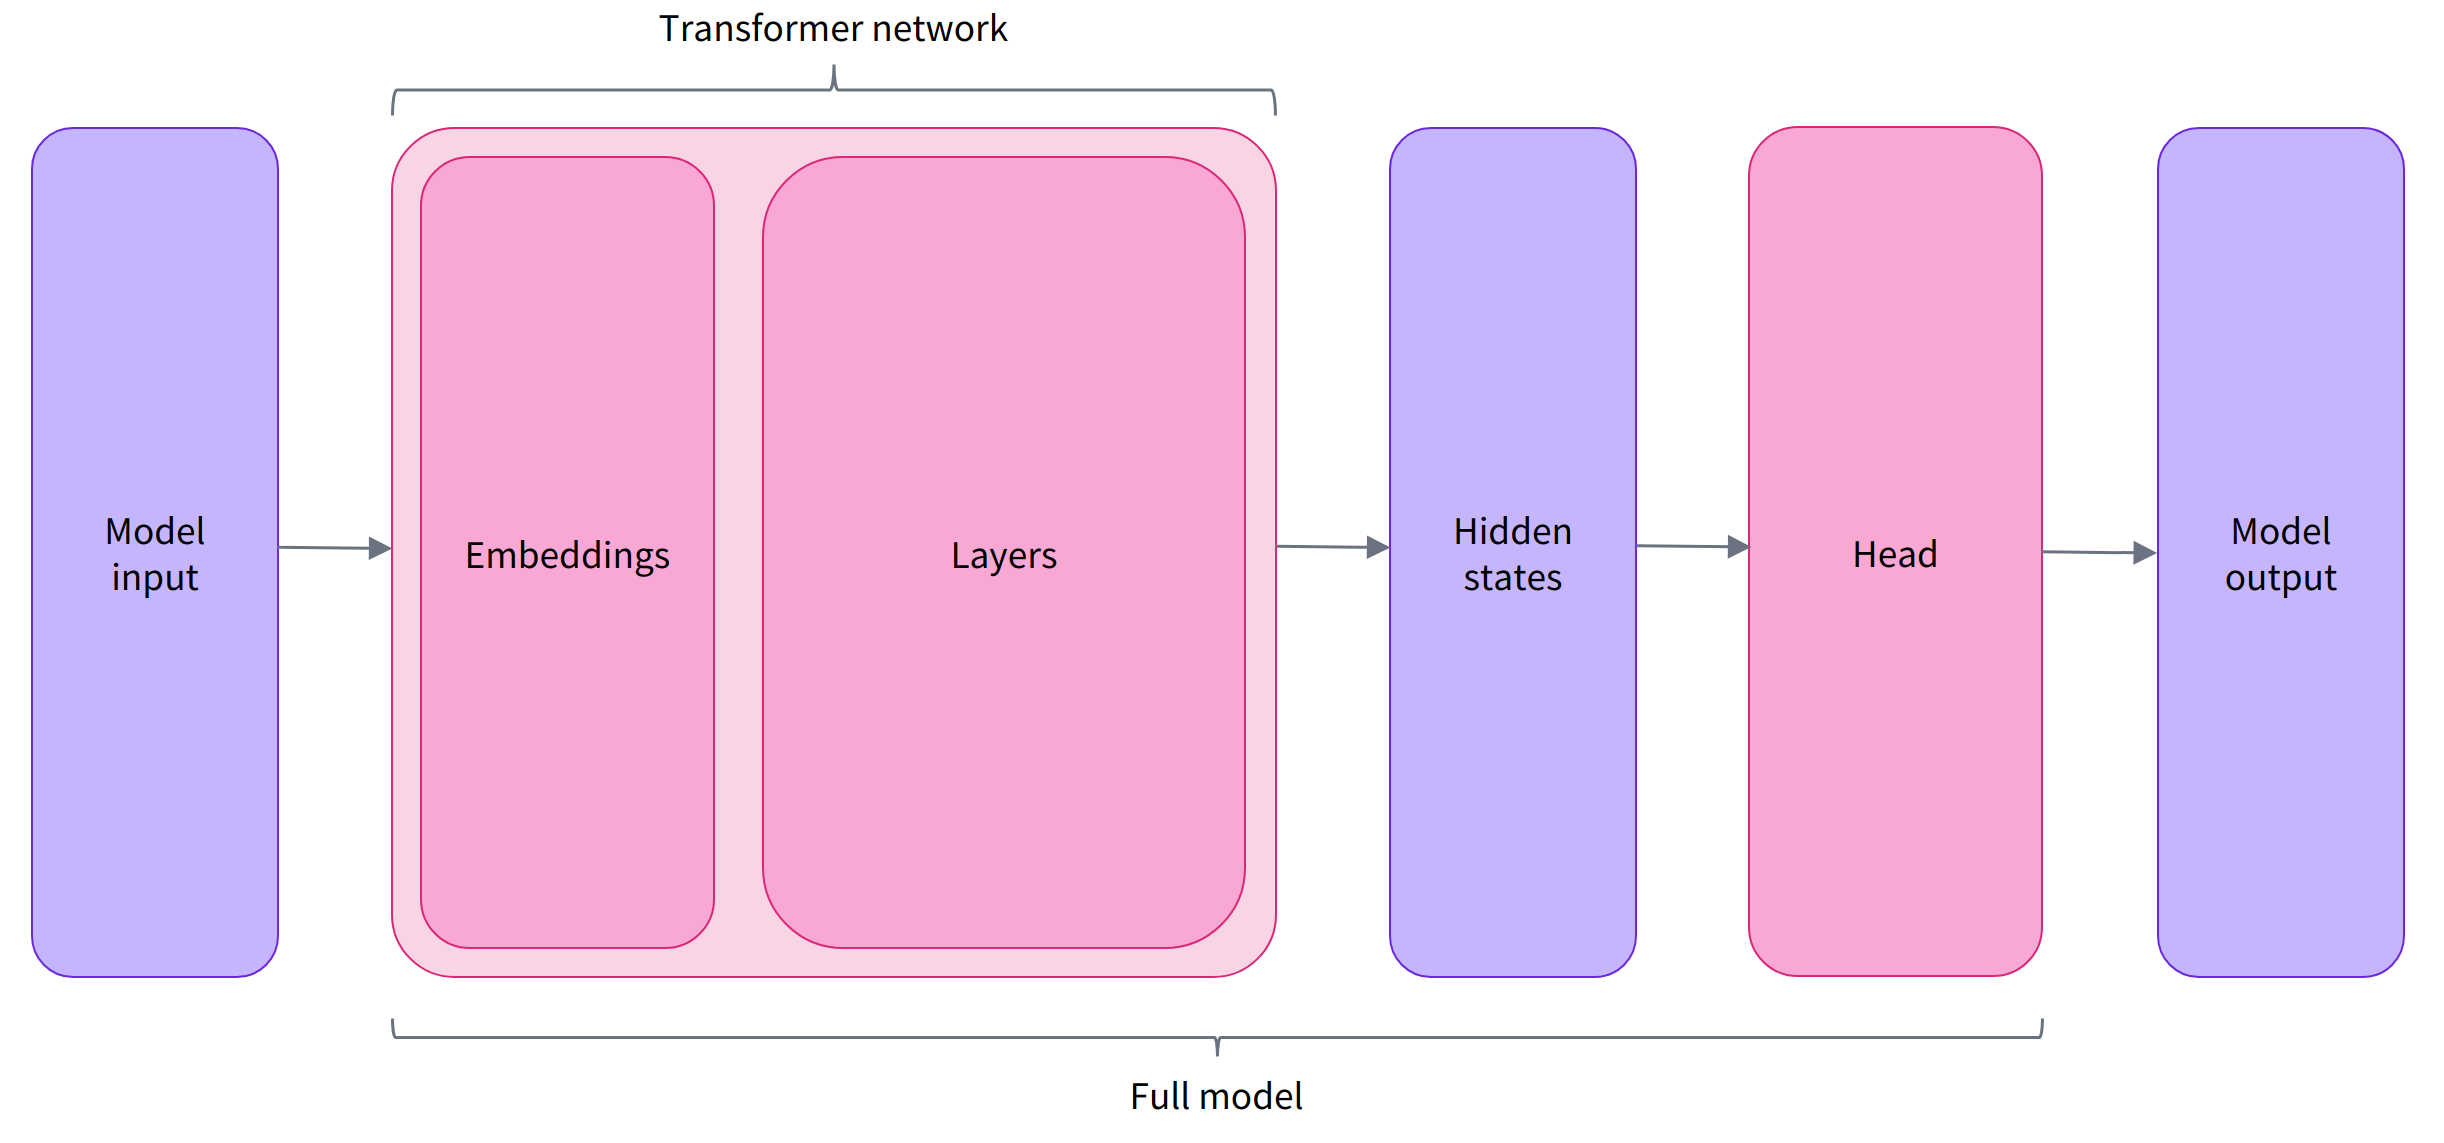


Here are some examples.
```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.


In [11]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bia

We get a warning here because the sequence classification parameters haven't been trained yet.

Passing inputs to the model is super easy. They take inputs as keyword arguments

In [12]:
model_inputs = tokenizer(input_str, return_tensors="pt")

# Option 1
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

# Option 2 - the keys of the dictionary the tokenizer returns are the same as the keyword arguments
#            the model expects

# f({k1: v1, k2: v2}) = f(k1=v1, k2=v2)

model_outputs = model(**model_inputs)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0979, -0.1616]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Distribution over labels: tensor([[0.5159, 0.4841]], grad_fn=<SoftmaxBackward0>)


If you notice, it's a bit weird that we have two classes for a binary classification task - you could easily have a single class and just choose a threshold. It's like this because of how huggingface models calculate the loss. This will increase the number of parameters we have, but shouldn't otherwise affect performance.

These models are just Pytorch Modules! You can can calculate the loss with your `loss_func` and call `loss.backward`. You can use any of the optimizers or learning rate schedulers that you used

You can calculate the loss like normal

In [13]:
label = torch.tensor([1])
loss = torch.nn.functional.cross_entropy(model_outputs.logits, label)
print(loss)
loss.backward()

tensor(0.7255, grad_fn=<NllLossBackward0>)


You can get the parameters

In [14]:
list(model.named_parameters())[0]

('distilbert.embeddings.word_embeddings.weight',
 Parameter containing:
 tensor([[-2.5130e-02, -3.3044e-02, -2.4396e-03,  ..., -1.0848e-02,
          -4.6824e-02, -9.4855e-03],
         [-4.8244e-03, -2.1486e-02, -8.7145e-03,  ..., -2.6029e-02,
          -3.7862e-02, -2.4103e-02],
         [-1.6531e-02, -1.7862e-02,  1.0596e-03,  ..., -1.6371e-02,
          -3.5670e-02, -3.1419e-02],
         ...,
         [-9.6466e-03,  1.4814e-02, -2.9182e-02,  ..., -3.7873e-02,
          -4.6263e-02, -1.6803e-02],
         [-1.3170e-02,  6.5378e-05, -3.7222e-02,  ..., -4.3558e-02,
          -1.1252e-02, -2.2152e-02],
         [ 1.1905e-02, -2.3293e-02, -2.2506e-02,  ..., -2.7136e-02,
          -4.3556e-02,  1.0529e-04]], requires_grad=True))

Hugging Face provides an additional easy way to calculate the loss as well:

To calculate the loss, we need to pass in a label:

In [15]:
model_inputs = tokenizer(input_str, return_tensors="pt")

labels = ['NEGATIVE', 'POSITIVE']
model_inputs['labels'] = torch.tensor([1])

model_outputs = model(**model_inputs)


print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")

SequenceClassifierOutput(loss=tensor(0.7255, grad_fn=<NllLossBackward0>), logits=tensor([[-0.0979, -0.1616]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Model predictions: NEGATIVE


### 1.3 Model Outputs: hidden states and attentions weights
You can get the hidden states and attention weights from a model by passing the optional arguments `output_hidden_states=True` and `output_attentions=True`.

The hidden states are a matrix of weights for each token and for each layer in the transformer.

The attentions weights are matrices of attentions between each other token: there are multiple matrices according to the number of heads and these are present for each layer in the model.

These weights is particularly helpful if you're working on an analysis project. (For example, see [What does BERT look at?](https://arxiv.org/abs/1906.04341)).

For example, one can use the hidden weights as contextual representations for the tokens, using either the values in the top layer, or averaging the values in a few top layers (typically 4) or across all the layers.

In [16]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                                # y-axis is query, x-axis is key

In [22]:
len(model_output.attentions), len(model_output.hidden_states), model_output.last_hidden_state.shape

(6, 7, torch.Size([1, 9, 768]))

### 1.4 Display the Attention heads for each layer

The attentions heads for each layer in the model are matrices of attention scores between each other token.

The above model has 12 heads in each of its 6 layers.

['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!', '[SEP]']


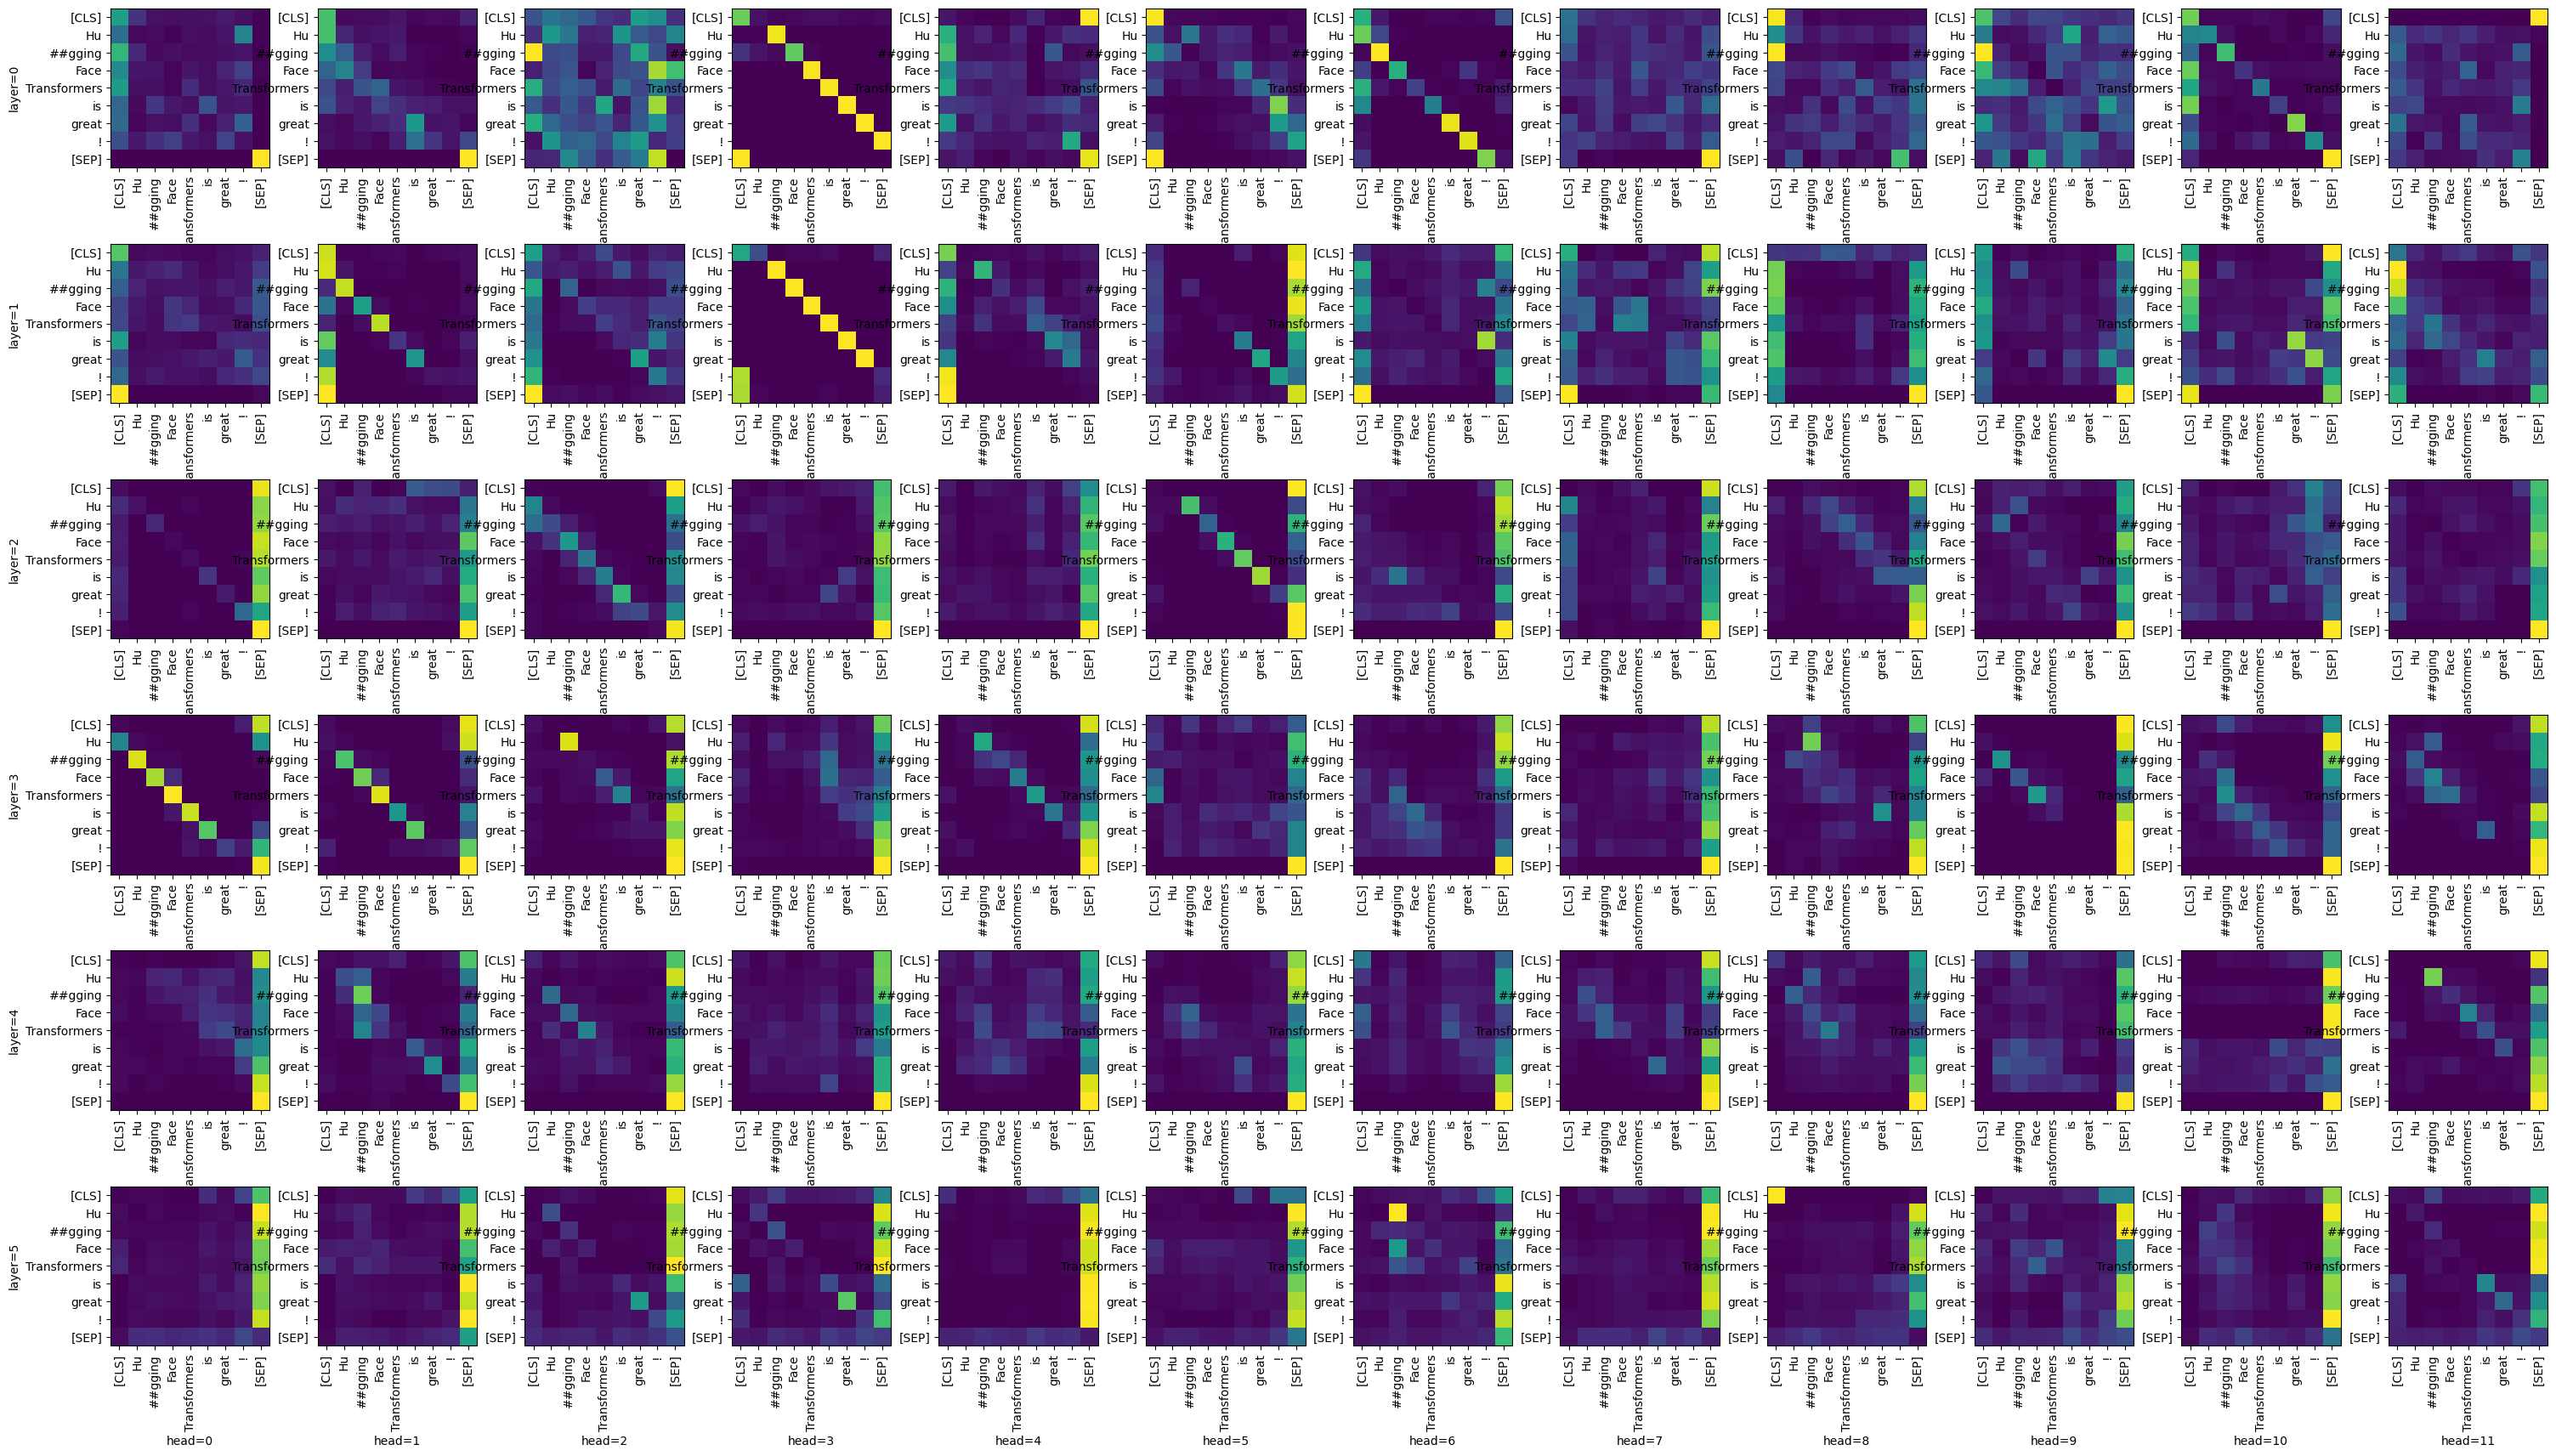

In [23]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)

n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(9)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(9)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")
            
plt.subplots_adjust(wspace=0.3)
plt.show()

It looks like for example the 4th attention head in layer 0 relates each token with its successor, while the 6th to its predecessor. 

## Part 2: Fine-tuning

For your projects, you are much more likely to want to finetune a pretrained model. This is a little bit more involved, but is still quite easy.

### 2.1 Loading in a dataset

In addition to having models, the [the hub](https://huggingface.co/datasets) also has datasets.

In [24]:
from datasets import load_dataset, DatasetDict

imdb_dataset = load_dataset("imdb")

# Just take the first 50 tokens for speed/running on cpu
TRUNCATE = 50
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:TRUNCATE]),
        'label': example['label']
    }

# Take 128 random examples for train and 32 validation
TRAIN_SIZE = 128
VAL_SIZE = 32
small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(TRAIN_SIZE)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(VAL_SIZE, 160)).map(truncate),
)

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /home/medialab/attardi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Loading cached shuffled indices for dataset at /home/medialab/attardi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [25]:
small_imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 128
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 128
    })
})

In [26]:
small_imdb_dataset['train'][:10]

{'text': ["Probably Jackie Chan's best film in the 1980s, and the one that put him on the map. The scale of this self-directed police drama is evident from the opening and closing scenes, during which a squatters' village and shopping mall are demolished. There are, clearly, differences between the original Chinese",
  'A wonderful movie! Anyone growing up in an Italian family will definitely see themselves in these characters. A good family movie with sadness, humor, and very good acting from all. You will enjoy this movie!! We need more like it.',
  'HORRENDOUS! Avoid like the plague. I would rate this in the top 10 worst movies ever. Special effects, acting, mood, sound, etc. appear to be done by day care students...wait, I have seen programs better than this. Opens like a soft porn show with a blurred nude female doing a',
  'And I absolutely adore Isabelle Blais!!! She was so cute in this movie, and far different from her role in "Quebec-Montreal" where she was more like a man-eat

Prepare the dataset - this tokenizes the dataset in batches of 16 examples.

In [27]:
small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True),
    batched=True,
    batch_size=16
)

small_tokenized_dataset = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [28]:
small_tokenized_dataset['train'][0:2]

{'labels': tensor([1, 1]),
 'input_ids': tensor([[  101, 10109,  9662, 10185,   112,   188,  1436,  1273,  1107,  1103,
           3011,   117,  1105,  1103,  1141,  1115,  1508,  1140,  1113,  1103,
           4520,   119,  1109,  3418,  1104,  1142,  2191,   118,  2002,  2021,
           3362,  1110, 10238,  1121,  1103,  2280,  1105,  5134,  4429,   117,
           1219,  1134,   170,  4816,  6718, 18899,   112,  1491,  1105,  6001,
           8796,  1132,  6515,   119,  1247,  1132,   117,  3817,   117,  5408,
           1206,  1103,  1560,  1922,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,   138,  7310,  2523,   106, 15859,  2898,  1146,  1107,  1126,
           2169,  1266,  1209,  5397,  1267,  2310,  1107,  1292,  2650,   119,
            138,  1363,  1266,  2523,  1114, 12928,   1

In [29]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_tokenized_dataset['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset['val'], batch_size=16)

### 2.2 Training

To train your models, you can just use the same kind of training loop that you would use in Pytorch. Hugging Face models are also `torch.nn.Module`s so backpropagation happens the same way and you can even use the same optimizers. Hugging Face also includes optimizers and learning rate schedules that were used to train Transformer models, so you can use these too.

For optimization, we're using the AdamW Optimizer, which is almost identical to Adam except it also includes weight decay.
And we're using a linear learning rate scheduler, which reduces the learning rate a little bit after each training step over the course of training.

There are other optimizers and learning rate schedulers you can use, but these are the default. If you want to explore, you can look at the ones [Hugging Face offers](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules), the ones available through [Pytorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) (e.g. [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), which only decreases the learning rate when the validation loss stops decreasing), or write your own.

Warmup steps is a parameter used to lower the learning rate in the first training steps, in order to reduce the impact of sudden exposure to data.

In [30]:
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

num_epochs = 3
num_training_steps = 3 * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # training
    model.train()
    for batch_i, batch in enumerate(train_dataloader):
        
        # batch = ([text1, text2], [0, 1])

        output = model(**batch)
        
        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    
    # validation
    model.eval()
    loss = 0.0
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            output = model(**batch)
        loss += output.loss
    
    avg_val_loss = loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"checkpoints/epoch_{epoch}.pt"
        )  

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bia

  0%|          | 0/24 [00:00<?, ?it/s]

Validation loss: 0.6819130182266235
Saving checkpoint!
Validation loss: 0.6558282375335693
Saving checkpoint!
Validation loss: 0.6319156885147095
Saving checkpoint!


### 2.2.1 Trainer

While you can use PyTorch to train your models, Hugging Face offers a powerful `Trainer` class to handle most needs. I think it works pretty well, though there are some customizations I'd recommend.

In [31]:
imdb_dataset = load_dataset("imdb")

small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], truncation=True),
    batched=True,
    batch_size=16
)

Found cached dataset imdb (/home/medialab/attardi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/medialab/attardi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow
Loading cached processed dataset at /home/medialab/attardi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-384c772657de307d.arrow
Loading cached shuffled indices for dataset at /home/medialab/attardi/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-44ad9ef44a26214e.arrow


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

`TrainingArguments` specifies different training parameters like how often to evaluate and save model checkpoints, where to save them, etc. There are **many** aspects you can customize and it's worth checking them out [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). Some things you can control include:
* learning rate, weight decay, gradient clipping, 
* checkpointing, logging, and evaluation frequency
* where you log to (default is tensorboard, but if you use WandB or MLFlow they have integrations)

The `Trainer` actually performs the training. You can pass it the `TrainingArguments`, model, the datasets, tokenizer, optimizer, and even model checkpoints to resume training from. The `compute_metrics` function is called at the end of evaluation/validation to calculate evaluation metrics.

In [32]:
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

arguments = TrainingArguments(
    output_dir="sample_hf_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=224
)


def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bia

#### Callbacks: Logging and Early Stopping


Hugging Face Transformers also allows you to write `Callbacks` if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping, and I usually write one for logging as well.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

In [33]:
from transformers import TrainerCallback, EarlyStoppingCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting 
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")


trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("sample_hf_trainer/log.jsonl"))

### 2.3 Train the model

In [34]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.679195,0.562500
2,No log,0.678718,0.656250
3,No log,0.677954,0.656250


TrainOutput(global_step=24, training_loss=0.6793535550435384, metrics={'train_runtime': 74.0494, 'train_samples_per_second': 5.186, 'train_steps_per_second': 0.324, 'train_loss': 0.6793535550435384, 'epoch': 3.0})

### 2.4 Evaluate the model

In [35]:
# results = trainer.evaluate()                           # just gets evaluation metrics
results = trainer.predict(small_tokenized_dataset['val']) # also gives you predictions

In [36]:
results

PredictionOutput(predictions=array([[ 0.07282554,  0.09410509],
       [ 0.06998976,  0.09225507],
       [ 0.10334364,  0.0571552 ],
       [ 0.12052149,  0.0845656 ],
       [ 0.00623405,  0.1817092 ],
       [ 0.11518575,  0.06513221],
       [ 0.12636533, -0.0219942 ],
       [ 0.12776965,  0.08958104],
       [ 0.05436328,  0.09767304],
       [ 0.04600054,  0.07990567],
       [ 0.07943599,  0.09505176],
       [ 0.19438666,  0.00597538],
       [ 0.1352027 ,  0.04371324],
       [ 0.12513372,  0.08733289],
       [ 0.16179669,  0.08023666],
       [ 0.1745914 ,  0.00335244],
       [ 0.17229292, -0.00734432],
       [ 0.05696238,  0.12496936],
       [ 0.10597938,  0.06503016],
       [ 0.03005559,  0.1452572 ],
       [ 0.1702131 , -0.00725833],
       [ 0.10802095,  0.09089527],
       [ 0.09125648,  0.06214113],
       [ 0.11244147,  0.04449213],
       [ 0.08886635,  0.11490916],
       [ 0.06212916,  0.0808822 ],
       [ 0.01815089,  0.09405833],
       [ 0.10025966,  0.04

### Load a model
To load our saved model, we can pass the path to the checkpoint into the `from_pretrained` method:

In [37]:
test_str = "I enjoyed the movie!"

finetuned_model = AutoModelForSequenceClassification.from_pretrained("sample_hf_trainer/checkpoint-24")
model_inputs = tokenizer(test_str, return_tensors="pt")
prediction = torch.argmax(finetuned_model(**model_inputs).logits)
print(["NEGATIVE", "POSITIVE"][prediction])

POSITIVE


Included here are also some practical tips for fine-tuning:

**Good default hyperparameters.** The hyperparameters you will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* Epochs: {2, 3, 4} (larger amounts of data need fewer epochs)
* Batch size (bigger is better: as large as you can make it)
* Optimizer: AdamW
* AdamW learning rate: {2e-5, 5e-5}
* Learning rate scheduler: linear warm up for first {0, 100, 500} steps of training
* weight_decay (l2 regularization): {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful including logging, saving model checkpoints, and more! You can even sub-class it to add your own personalized components. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about the Trainer.

## Appendix 0: Generation

In the example above we finetuned the model on a classification task, but you can also finetune models on generation tasks. The `generate` function makes it easy to generate from these models. For example.

In [38]:
from transformers import AutoModelForCausalLM

gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id  # Prevents warning during decoding

In [39]:
prompt = "Once upon a time"

tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

for i in range(10):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


1) Once upon a time, a large percentage of U.S. citizens were born in the United States and Canada. But in fact, even more, more of them are American citizens living in the United States. The number of U.S. citizens
2) Once upon a time of high prosperity, sophistication, and creativity, you've got to work with the creative side.



But the challenge for those who enjoy the art world is to get creative in its own way.
Now with a
3) Once upon a time of reckoning and confusion and despair the world becomes a battlefield of war, war, and suffering.


The last act of a fight for the truth has now become the battle of truth and courage. The power that men have
4) Once upon a time of the year, a woman was dying from heat and dehydration. She was dying at a nursing home that had been burned down for the better part of the century. When a white man, a black man, was burned down,
5) Once upon a time of the war, I believe that the future of the future should be based on the destruction of the wor

## Appendix 1: Defining Custom Datasets

There are a few ways to go about defining datasets, but I'm going to show an example using Pytorch `Dataloader`'s. This example uses an encoder-decoder dataset,the [E2E Dataset](https://arxiv.org/abs/1706.09254), which is maps structured information about restaurants to natural language descriptions.

## Option 1: Load into Hugging Face Datasets

import pandas as pd
from datasets import Dataset

df = pd.read_csv("e2e-dataset/trainset.csv")
custom_dataset = Dataset.from_pandas(df)

In [36]:
import csv
from torch.utils.data import Dataset, DataLoader

class E2EDataset(Dataset):
    """Tokenize data when we call __getitem__"""
    def __init__(self, path, tokenizer):
        with open(path, newline="") as f:
            reader = csv.reader(f)
            next(reader) # skip the heading
            self.data = [{"source": row[0], "target": row[1]} for row in reader]
        self.tokenizer = tokenizer
            
    def __getitem__(self, i):
        inputs = self.tokenizer(self.data[i]['source'])
        labels = self.tokenizer(self.data[i]['target'])
        inputs['labels'] = labels.input_ids
        return inputs


In [37]:
bart_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/facebook/bart-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/medialab/attardi/.cache/huggingface/transformers/tmpiygiz3y5


Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/bart-base/resolve/main/config.json in cache at /home/medialab/attardi/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.a243ed957122436adb0b8d8e9d20f896f45c174b6324d625ca0a20a84f72a910
creating metadata file for /home/medialab/attardi/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.a243ed957122436adb0b8d8e9d20f896f45c174b6324d625ca0a20a84f72a910
loading configuration file https://huggingface.co/facebook/bart-base/resolve/main/config.json from cache at /home/medialab/attardi/.cache/huggingface/transformers/f5310d276a6d1648d00c32fadc8bf7b4607e0fbd5b404fc4a0045960aa2bdfdb.a243ed957122436adb0b8d8e9d20f896f45c174b6324d625ca0a20a84f72a910
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartMod

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/bart-base/resolve/main/vocab.json in cache at /home/medialab/attardi/.cache/huggingface/transformers/43978bdeaa326572886b44fcfed82f932f76571095ce31973e51c3da8ccade7f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /home/medialab/attardi/.cache/huggingface/transformers/43978bdeaa326572886b44fcfed82f932f76571095ce31973e51c3da8ccade7f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/facebook/bart-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /home/medialab/attardi/.cache/huggingface/transformers/tmp325fjgtb


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/facebook/bart-base/resolve/main/merges.txt in cache at /home/medialab/attardi/.cache/huggingface/transformers/3c167ed8af56e6605eeb794b63a79d65d85e6708c9b04408d41946337030f5cd.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /home/medialab/attardi/.cache/huggingface/transformers/3c167ed8af56e6605eeb794b63a79d65d85e6708c9b04408d41946337030f5cd.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/facebook/bart-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /home/medialab/attardi/.cache/huggingface/transformers/tmp45t1jmv_


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/facebook/bart-base/resolve/main/tokenizer.json in cache at /home/medialab/attardi/.cache/huggingface/transformers/a878fcd69bba037c9b1b227f4213579ae43d0aaa9374e167bc6c5f41b1cfeb30.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /home/medialab/attardi/.cache/huggingface/transformers/a878fcd69bba037c9b1b227f4213579ae43d0aaa9374e167bc6c5f41b1cfeb30.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/facebook/bart-base/resolve/main/vocab.json from cache at /home/medialab/attardi/.cache/huggingface/transformers/43978bdeaa326572886b44fcfed82f932f76571095ce31973e51c3da8ccade7f.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/facebook/bart-base/resolve/main/merges.txt from cache at /home/medialab/attardi/.cache/huggingface/transformers/3c167ed8af56e6605eeb794b63a79d65d85e6708c9b04408d41946337030f5cd.5d12962c5ee615a4c80384

In [38]:
dataset = E2EDataset("e2e-dataset/trainset.csv", bart_tokenizer)

In [39]:
bart_tokenizer.prepare_seq2seq_batch(src_texts=["This is the first test.", "This is the second test."], tgt_texts=["Target 1", "Target 2"], return_tensors="pt")

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3524: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


{'input_ids': tensor([[   0,  713,   16,    5,   78, 1296,    4,    2],
        [   0,  713,   16,    5,  200, 1296,    4,    2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[    0, 41858,   112,     2],
        [    0, 41858,   132,     2]])}

In [40]:
dataset[0]

{'input_ids': [0, 13650, 10975, 133, 48596, 7479, 3529, 40118, 10975, 22478, 7479, 425, 43430, 10975, 4321, 87, 984, 541, 7479, 2111, 691, 10975, 245, 66, 9, 195, 7479, 583, 10975, 347, 2001, 1140, 1614, 1069, 5183, 742, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [0, 133, 48596, 8881, 583, 22450, 1614, 1069, 5183, 34, 10, 195, 999, 691, 4, 1437, 14614, 386, 23, 984, 541, 4, 2]}

## Appendix 2: Pipelines

There are some standard NLP tasks like sentiment classification or question answering where there are already pre-trained (and fine-tuned!) models available through Hugging Face Transformer's [_Pipeline_](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/pipelines#transformers.pipeline) interface. 

For your projects, you likely won't be using it too much, but it's still worth knowing about!

Here's an example with Sentiment Analysis:

In [41]:
from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

loading configuration file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json from cache at /home/medialab/attardi/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidde

You can run the pipeline by just calling it on a string

In [42]:
sentiment_analysis("Hugging Face Transformers is really cool!")

[{'label': 'POSITIVE', 'score': 0.998448371887207}]

Or on a list of strings:

In [43]:
sentiment_analysis(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'POSITIVE', 'score': 0.9988769888877869},
 {'label': 'NEGATIVE', 'score': 0.9994940757751465}]

You can find more information on pipelines (including which ones are available) [here](https://huggingface.co/docs/transformers/main_classes/pipelines)

## Appendix 3: Masked Language Modeling

In [44]:
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", fast=True)
bert = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

https://huggingface.co/bert-base-cased/resolve/main/config.json not found in cache or force_download set to True, downloading to /home/medialab/attardi/.cache/huggingface/transformers/tmpz9u90ueb


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/config.json in cache at /home/medialab/attardi/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
creating metadata file for /home/medialab/attardi/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/medialab/attardi/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

storing https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin in cache at /home/medialab/attardi/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
creating metadata file for /home/medialab/attardi/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from cache at /home/medialab/attardi/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedL

In [45]:
prompt = "I am [MASK] to learn about HuggingFace!"
model = pipeline("fill-mask", "bert-base-cased")
model(prompt)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/medialab/attardi/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading configuration file https://huggingface.co/b

[{'score': 0.3552907705307007,
  'token': 7215,
  'token_str': 'excited',
  'sequence': 'I am excited to learn about HuggingFace!'},
 {'score': 0.1562114804983139,
  'token': 1280,
  'token_str': 'going',
  'sequence': 'I am going to learn about HuggingFace!'},
 {'score': 0.07893471419811249,
  'token': 9582,
  'token_str': 'eager',
  'sequence': 'I am eager to learn about HuggingFace!'},
 {'score': 0.035599637776613235,
  'token': 1303,
  'token_str': 'here',
  'sequence': 'I am here to learn about HuggingFace!'},
 {'score': 0.03524087369441986,
  'token': 17261,
  'token_str': 'delighted',
  'sequence': 'I am delighted to learn about HuggingFace!'}]

In [46]:
inputs = tokenizer(prompt, return_tensors="pt")
mask_index = np.where(inputs['input_ids'] == tokenizer.mask_token_id)
outputs = bert(**inputs)
top_5_predictions = torch.softmax(outputs.logits[mask_index], dim=1).topk(5)

print(prompt)
for i in range(5):
    prediction = tokenizer.decode(top_5_predictions.indices[0, i])
    prob = top_5_predictions.values[0, i]
    print(f"  {i+1}) {prediction}\t{prob:.3f}")

I am [MASK] to learn about HuggingFace!
  1) excited	0.355
  2) going	0.156
  3) eager	0.079
  4) here	0.036
  5) delighted	0.035
